In [17]:
import sys
import os
os.environ['USE_PYGEOS'] = '0'
import gc
import collections
from pathlib import Path

import cartopy.crs as ccrs
import cartopy
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams, cycler
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import geopandas as gpd
from statsmodels.tsa.seasonal import seasonal_decompose


import numpy as np
import xarray as xr
from xeofs.xarray import EOF
import rioxarray

import dask
import distributed

import scipy
from scipy import signal
import cftime
from shapely.geometry import mapping
from xarrayutils.utils import linear_trend, xr_linregress
import pandas as pd
import cmocean

In [2]:
# FIXIT: Jupyter Lab scheduler view for Dask not working
client = distributed.Client()
client

2024-02-08 12:21:44,565 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/6b/9ftjhcg16g19w33zvk7zd7mm0131yc/T/dask-worker-space/worker-7lqii4qy', purging
2024-02-08 12:21:44,567 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/6b/9ftjhcg16g19w33zvk7zd7mm0131yc/T/dask-worker-space/worker-ixajvp5i', purging
2024-02-08 12:21:44,567 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/6b/9ftjhcg16g19w33zvk7zd7mm0131yc/T/dask-worker-space/worker-kw5yzhzh', purging
2024-02-08 12:21:44,568 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/6b/9ftjhcg16g19w33zvk7zd7mm0131yc/T/dask-worker-space/worker-o_vvu5kt', purging
2024-02-08 12:21:44,569 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/6b/9ftjhcg16g19w33zvk7zd7mm0131yc/T/dask-worker-space/worker-mbenpycg', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 5
Total threads: 10,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:59161,Workers: 5
Dashboard: http://127.0.0.1:8787/status,Total threads: 10
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:59176,Total threads: 2
Dashboard: http://127.0.0.1:59181/status,Memory: 3.20 GiB
Nanny: tcp://127.0.0.1:59164,


# Read dataset

In [43]:
# File path directories

# inDirName = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

# Get full path of the aislens_emulation directory. All file IO is relative to this path.
main_dir = Path.cwd().parent
#dir_ext_data = 'data/external/'
#dir_interim_data = 'data/interim/'
DIR_external = 'data/external/'
DIR_processed = 'data/processed/'
FILE_MeltDraftObs = 'ANT_G1920V01_IceShelfMeltDraft.nc'
FILE_basalMeltObs_deSeasonalized = 'obs23_melt_anm.nc'
FILE_iceShelvesShape = 'iceShelves.geojson'

In [44]:
ICESHELVES_MASK = gpd.read_file(main_dir / DIR_external / FILE_iceShelvesShape)
icems = ICESHELVES_MASK.to_crs({'init': 'epsg:3031'});
crs = ccrs.SouthPolarStereo();

/Users/smurugan9/opt/anaconda3/envs/aislens/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [4]:
MELTDRAFT_OBS = xr.open_dataset(main_dir / DIR_external / FILE_MeltDraftObs, chunks={"x":729, "y":729})
obs23_melt = MELTDRAFT_OBS.melt
obs23_draft = MELTDRAFT_OBS.draft

# Time series of spatial mean melt
obs23_melt_ts = obs23_melt.mean(dim=['x', 'y']).compute()

# Time mean of melt rate and draft
obs23_melt_tm = obs23_melt.mean(dim='time').compute()
obs23_draft_tm = obs23_draft.mean(dim='time').compute()

In [9]:
# Remove seasonality from the time series
# Check draft dependence on the residuals
# Check the residuals for spatial correlation

obs23_melt_anm = xr.open_dataset(main_dir / DIR_processed / FILE_basalMeltObs_deSeasonalized, chunks={"x":729, "y":729})
obs23_melt_anm_ts = obs23_melt_anm.melt.mean(dim=['x', 'y']).compute()

(2500.0, 0.0)

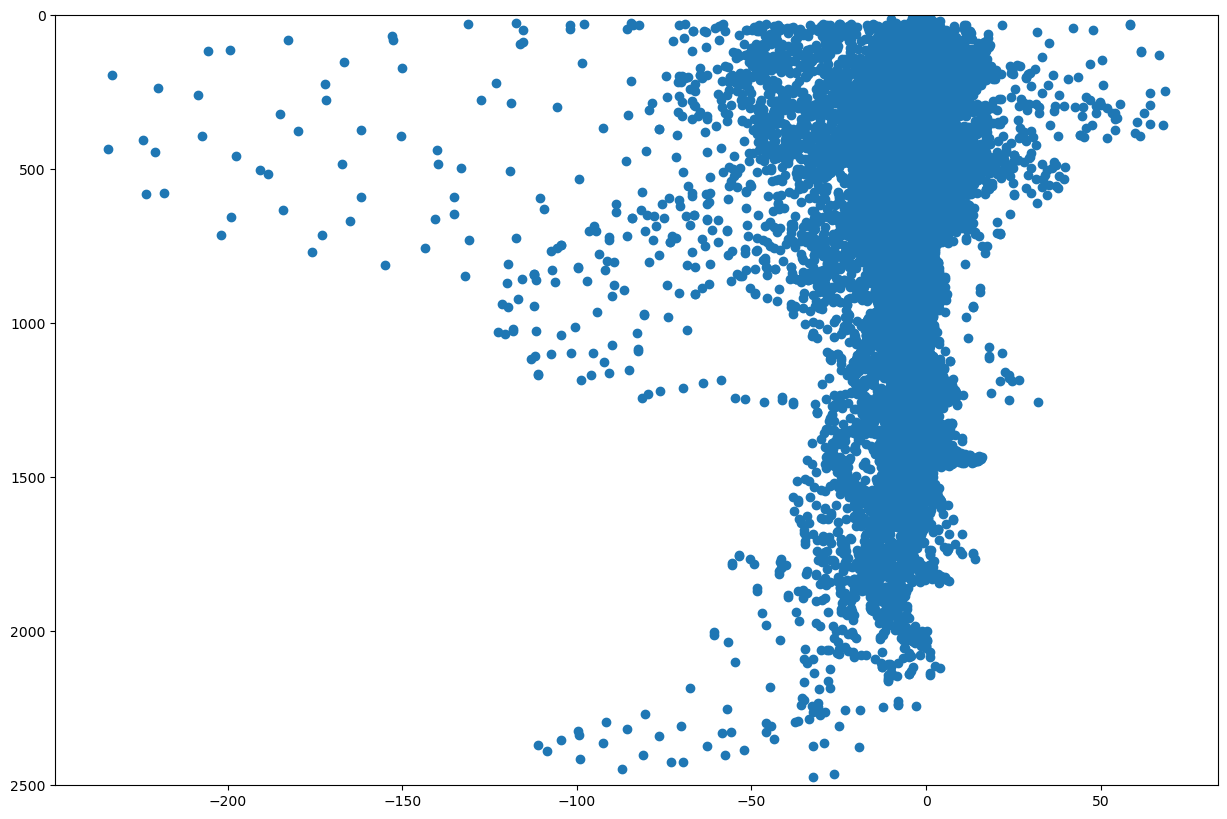

In [7]:


plt.figure(figsize=(15,10))
plt.scatter(obs23_melt_tm, obs23_draft_tm)
plt.ylim(2500,0)

In [ ]:
# Deseasonalize: Remove climatologies to isolate anomalies / deseasonalize
obs23_melt_month = obs23_melt.groupby("time.month")
obs23_melt_clm = obs23_melt_month.mean("time").compute() # Climatologies
obs23_melt_anm = (obs23_melt_month - obs23_melt_clm).compute() # Deseasonalized anomalies

In [ ]:
obs23_melt_anm_ts = obs23_melt_anm.mean(['x', 'y']).compute()

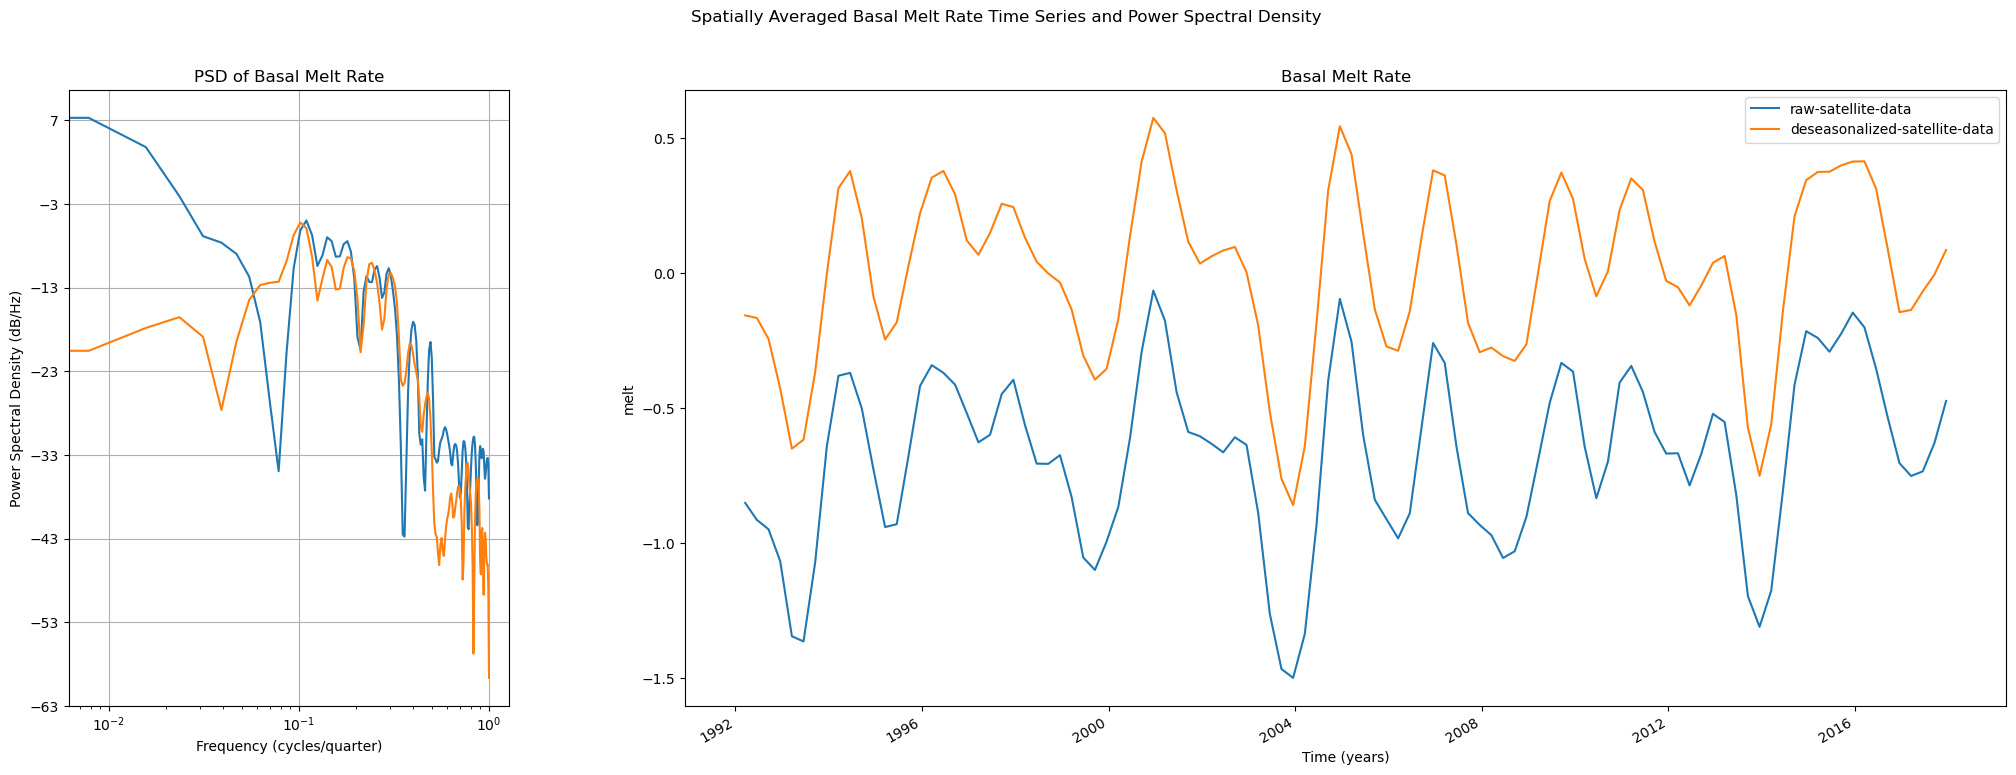

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(25, 8), gridspec_kw={'width_ratios': [1, 3]})

axs[0].psd(obs23_melt_ts);
axs[0].psd(obs23_melt_anm_ts);
axs[0].set_xlabel('Frequency (cycles/quarter)')
axs[0].set_xscale('log')
axs[0].set_title('PSD of Basal Melt Rate')

obs23_melt_ts.plot(ax=axs[1], label='raw-satellite-data')
obs23_melt_anm_ts.plot(ax=axs[1], label='deseasonalized-satellite-data')
#axs[1].plot(obs23_melt_ts)
axs[1].set_xlabel('Time (years)')
axs[1].set_title('Basal Melt Rate')

plt.legend()
fig.suptitle('Spatially Averaged Basal Melt Rate Time Series and Power Spectral Density')
plt.show()

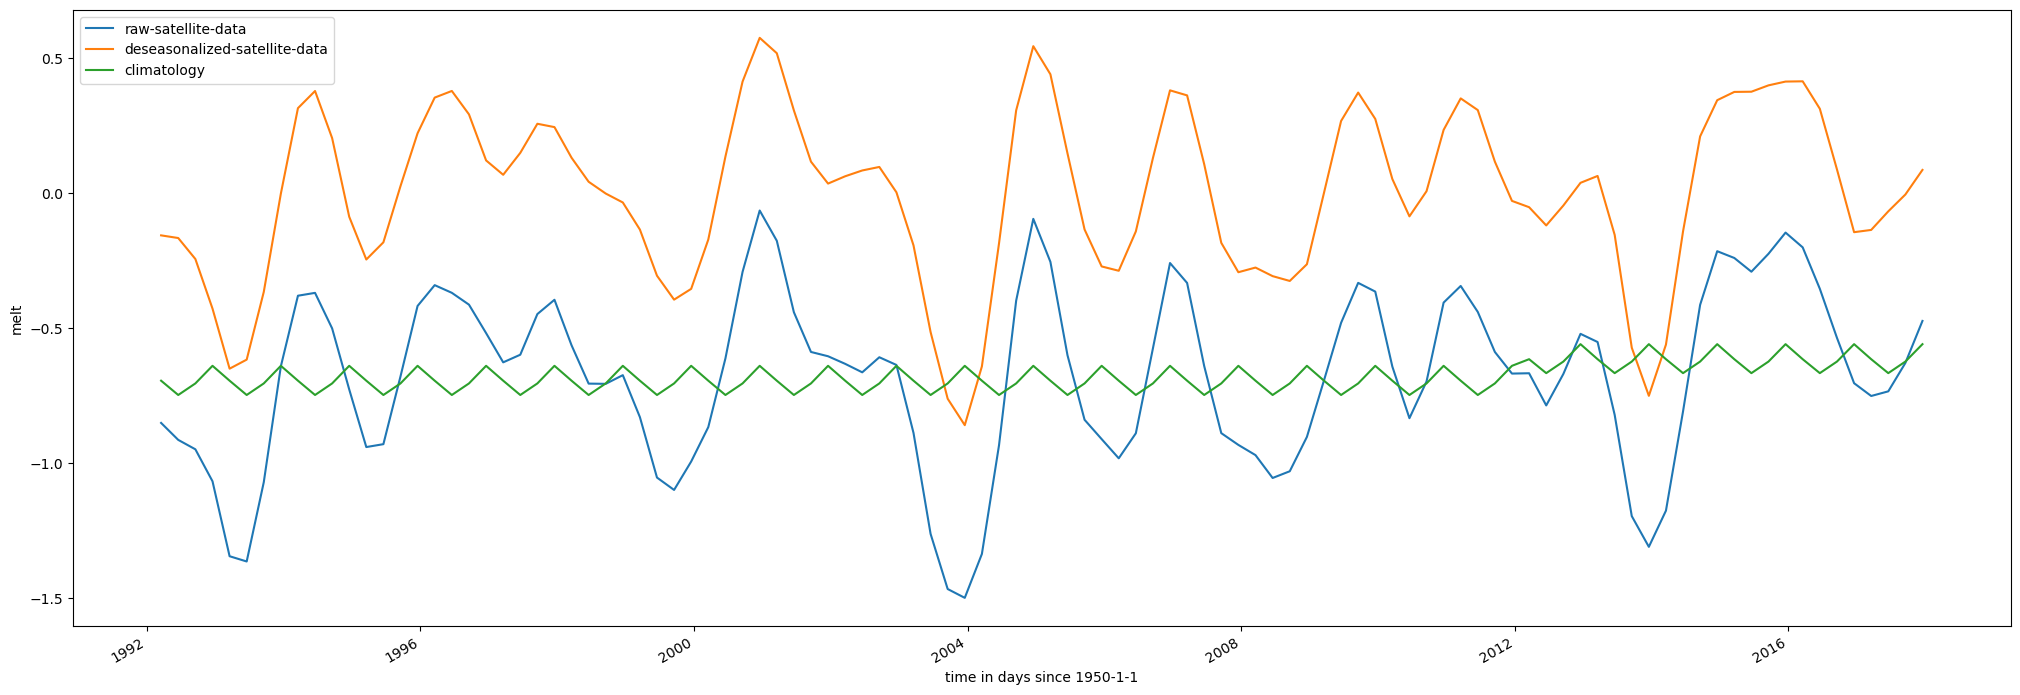

In [16]:
plt.figure(figsize=(25,8))
obs23_melt_ts.plot(label='raw-satellite-data')
obs23_melt_anm_ts.plot(label='deseasonalized-satellite-data')
(obs23_melt_ts - obs23_melt_anm_ts).plot(label='climatology')
#axs[1].plot(obs23_melt_ts)
axs[1].set_xlabel('Time (years)')
axs[1].set_title('Basal Melt Rate')

plt.legend()

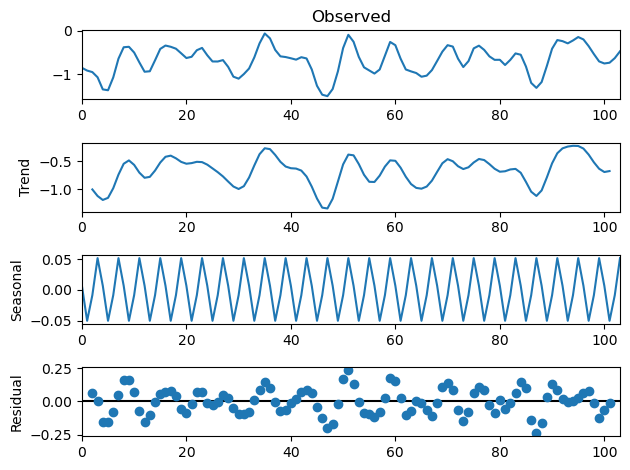

In [33]:
seasonal_decompose(obs23_melt_ts, model='additive', period=4).plot();

In [34]:
# Spatial mean of the deseasonalized melt rate
obs23_melt_anm_tm = obs23_melt_anm.mean(dim='time').compute()

In [38]:
obs23_melt_anm_tm = obs23_melt_anm_tm.melt

(2500.0, 0.0)

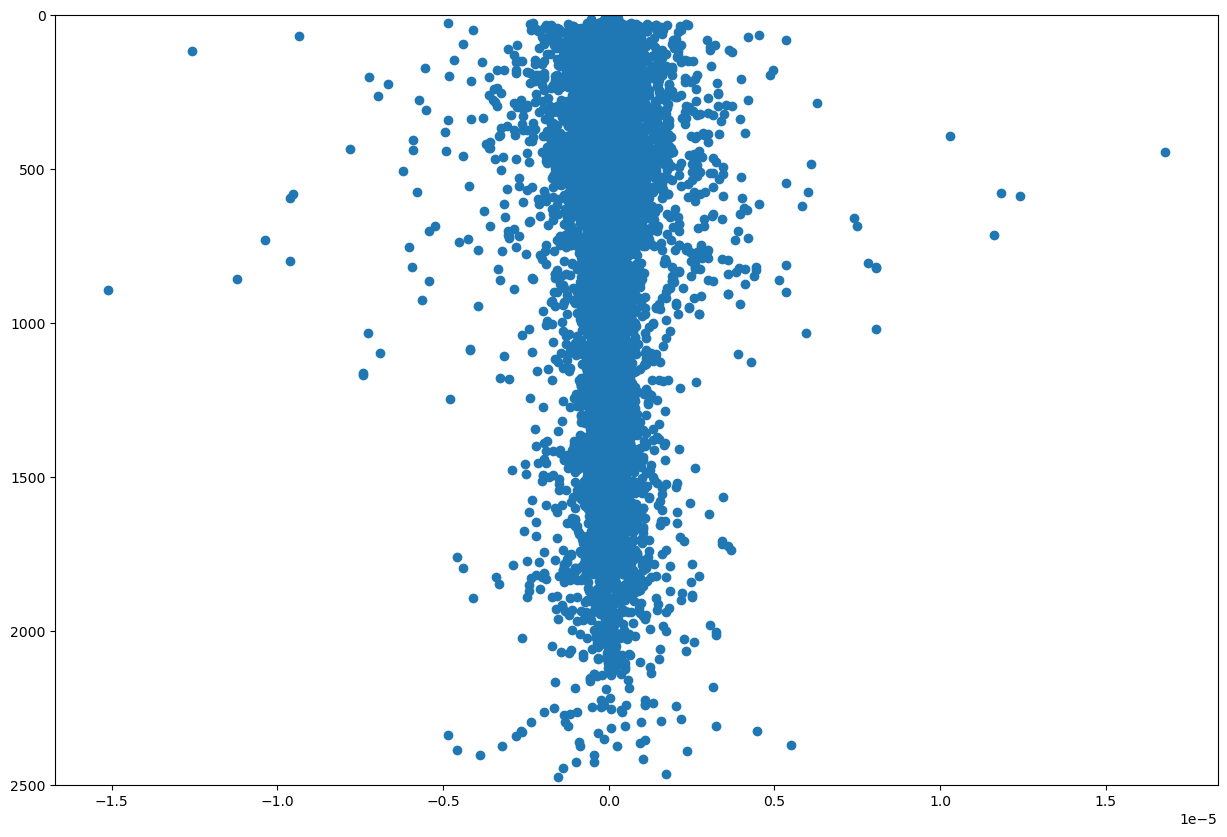

In [39]:
plt.figure(figsize=(15,10))
plt.scatter(obs23_melt_anm_tm, obs23_draft_tm)
plt.ylim(2500,0)

In [53]:
obs23_melt_anm_tm.rio.write_crs("epsg:3031",inplace=True);
obs23_draft_tm.rio.write_crs("epsg:3031",inplace=True);

obs23_melt_tm.rio.write_crs("epsg:3031",inplace=True);


In [46]:
def clip_data(total_data, basin):
    clipped_data = total_data.rio.clip(icems.loc[[basin],'geometry'].apply(mapping),icems.crs)
    #clipped_data = clipped_data.dropna('time',how='all')
    #clipped_data = clipped_data.dropna('y',how='all')
    #clipped_data = clipped_data.dropna('x',how='all')
    #clipped_data = clipped_data.drop("month")
    return clipped_data

In [ ]:
IMBIEregions = range(6,33)
iceShelfRegions = range(33,133)

iceShelfRegions = range(6,16)

for i in iceShelfRegions:
    print('extracting data for catchment {}'.format(icems.name.values[i]))
    mltanm = clip_data(obs23_melt_tm, i)
    z = clip_data(obs23_draft_tm, i)
    plt.scatter(mltanm, z, marker='x', s=3)
    plt.ylim(2500,0)
    del mltanm, z
    print('deleted interim variables')
    gc.collect()

In [ ]:
# will need to use relative drafts here?